In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as ospath

In [2]:
excelfile = ospath.join('..','Serious games','Games','БД4_Лёгкая.xlsm')

In [3]:
Alldata = pd.read_excel(excelfile,sheet_name='Данные')
Games = pd.read_excel(excelfile,sheet_name='Игры')
print(Alldata.columns)
Games.columns

Index(['Game', 'Time', 'Subject', 'Group', 'GrSubject', 'Type', 'Gain',
       'Penalty', 'x', 's1', 's2', 's3', 'AcceptAdvice', 'CalcCount',
       'CalcAdviceCount', 'UseHelp'],
      dtype='object')


Index(['Session', 'Game', 'Date', 'Place', 'GamersCount', 'R',
       'Parametr1_alfa', 'Parametr2_beta', 'Mechname', 'GameMech',
       'Cooperation', 'talks', 'Name', 'Datafile', 'Sbjfile', 'стимул',
       'Group', 'Курс балла'],
      dtype='object')

In [4]:
YHGames=Games[(Games.Mechname=='yh') & (Games.GameMech=='agree')]
YHExpGames=Games[(Games.Mechname=='yh') & (Games.GameMech=='exp')]

In [6]:
YHData=Alldata[Alldata.Game.isin(YHGames.Game)]
YHEData=Alldata[Alldata.Game.isin(YHExpGames.Game)]

In [7]:
print(YHData.shape,YHEData.shape)

(1035, 16) (75, 16)


In [7]:
GLGames=Games[(Games.Mechname=='gl') & (Games.GameMech=='agree')]
GLData=Alldata[Alldata.Game.isin(GLGames.Game)]

In [8]:
GLEGames=Games[(Games.Mechname=='gl') & (Games.GameMech=='exp')]
GLEData=Alldata[Alldata.Game.isin(GLEGames.Game)]

In [8]:
GLData.shape

(2847, 16)

In [9]:
from scipy.spatial import distance

In [11]:
distance.cityblock([49,41,25],[38.3,38.3,38.3])

26.700000000000003

### График длин игр

In [64]:
gamelength=YHData[['Game','Time']].groupby('Game').max()

In [65]:
a=gamelength.sort_values(by='Time')

In [66]:
a['Game']=range(1,15)

In [67]:
b=a.rename(columns={'Time':'Game length'})

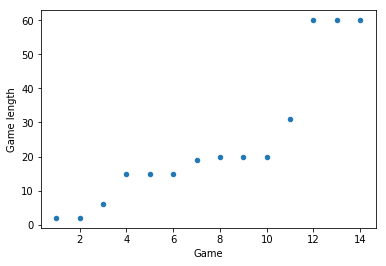

In [68]:
p=b.plot.scatter(x='Game',y='Game length')

In [69]:
p.get_figure().savefig('Gameslen.png',dpi=100)

In [31]:
GLData.axes

[Int64Index([6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583,
             6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594,
             6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605,
             6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616,
             6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627,
             6628, 6629, 6630, 6631, 6632],
            dtype='int64'),
 Index(['Game', 'Time', 'Subject', 'Group', 'GrSubject', 'Type', 'Gain',
        'Penalty', 'x', 's1', 's2', 's3', 'AcceptAdvice', 'CalcCount',
        'CalcAdviceCount', 'UseHelp'],
       dtype='object')]

In [40]:
GLData[['s1','s2','s3']].values[-1]

array([35., 35., 45.])

In [23]:
for i,v in zip(GLData['Time'].values,GLData[['s1','s2','s3']].values):
    print(type(v))
    break

<class 'numpy.ndarray'>


In [44]:
GLData['s2'].index

Int64Index([6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583,
            6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593, 6594,
            6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604, 6605,
            6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616,
            6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627,
            6628, 6629, 6630, 6631, 6632],
           dtype='int64')

### КП

In [8]:
def aheadCB(diter,eps,metric='cityblock'):
    """ return next CB start and stop and remaining iterator """
    from scipy.spatial import distance
    from itertools import chain as mchain
    start,vals = next(diter)
    vals = [ vals ]
    
    prev = start
    for i,v in diter:
        if np.asscalar(max(distance.cdist(vals,[v],metric))) > eps :
            return ((start,prev),mchain([(i,v)],diter))
        else:
            prev = i
            vals.append( v )
    return ((start,prev),diter)

def getCB(data,eps=0,metric='cityblock'): # colon data[0] must be 1,2,3,... to properly work of data[end-1] 
    from itertools import chain as mchain
    dend = data.index[-1]
    (start,end),diter = aheadCB(zip(data.index.values,data.values),eps,metric=metric)
    if start != end :
        cblist = [(start,end)]
        diter = mchain([(end,data.loc[end].values)],diter)
    else :
        cblist = []

    while end != dend :
        ((start,end),diter) = aheadCB(diter,eps)
        if start != end :
            cblist.append((start,end))
            diter = mchain([(end,data.loc[end].values)],diter)
    return cblist

In [23]:
['Game','Time','GrSubject']+(['s2'] if 1 == 2 else ['s1','s2','s3'])

['Game', 'Time', 'GrSubject', 's1', 's2', 's3']

In [9]:
def OnlySelfBidsOfGame(game): # s2 = sii
    shiftgame = game.copy()
    n = game.columns.get_loc('s1') - 1
    shiftgame.loc[:,'s2']=shiftgame.apply(lambda x: x[n+x['GrSubject']], axis=1)
    return shiftgame

def getCBwithEps(gamesdata, eps=0,dim=1,metric='cityblock'):    
    cols = ['s2'] if dim == 1 else ['s1','s2','s3']
    gr = gamesdata.loc[:,['Game','Time','GrSubject']+cols].groupby(['GrSubject','Game'])
    
    lst = []
    for (s,g),data in gr:
        data = data.set_index('Time')
        glen = data.index.max()
        if dim == 1:
            cb = getCB(data[cols],eps,metric=metric)
        else:
            cb = getCB(data[cols],eps,metric=metric)
        data = pd.DataFrame(cb,columns=['ts','te'])
        data['subject'] = s
        data['game'] = g
        data['gamelength'] = glen
        lst.append(data)
    return pd.concat(lst).reset_index(drop=True)
    
def getCBofAllGames(gamesdata, maxeps=10, dim=1,metric='cityblock'):
    if dim == 1:
        gr = gamesdata.loc[:,['Game','Time','GrSubject','s2']].groupby(['GrSubject','Game'])
    else:
        gr = gamesdata.loc[:,['Game','Time','GrSubject','s1','s2','s3']].groupby(['GrSubject','Game'])
    cbCounts, stepsCounts = [],[]
    for eps in range(maxeps+1):
        lst = []
        for (s,g),data in gr:
            data = data.set_index('Time')
            if dim == 1:
                cb = getCB(data[['s2']],eps,metric=metric)
            else:
                cb = getCB(data[['s1','s2','s3']],eps,metric=metric)
            data = pd.DataFrame(cb,columns=['ts','te'])
            data['subject'] = s
            data['game'] = g
            lst.append(data)
        cb = pd.concat(lst).reset_index(drop=True)
        cbCounts.append(cb.shape[0])
        stepsCounts.append((cb['te']-cb['ts']+1).sum())
    Counts = pd.DataFrame({'CB Count':cbCounts,'Steps Count':stepsCounts})
    Counts.index.name = 'eps'
    return Counts
def getCountsofCB(cbdata):
    pass

In [70]:
gr = YHData.loc[:,['Game','Time','GrSubject','s2']].groupby('Game')

In [72]:
game40_1=gr.get_group(40)
#game40_1 = game40_1[['Time','s2']].set_index('Time')

In [76]:
game40_1.sort_values(by=['Time','GrSubject'])['s2'].iloc[-3:]

2711    115.0
2709    115.0
2710    115.0
Name: s2, dtype: float64

In [63]:
for i,v in game40_1.items():
  print(i,v)

s2 Time
1       1.0
2       1.1
3       1.0
4       1.1
5     115.0
6       1.0
7       1.1
8       1.2
9      40.0
10     75.0
11     23.8
12      1.0
13    115.0
14     50.0
15     40.0
16     10.0
17     20.0
18     22.0
19     25.0
20     40.0
21     10.0
22     15.0
23      1.0
24      1.1
25      1.0
26      1.1
27      1.0
28      1.1
29      1.0
30      1.1
31      1.0
32     40.0
33     40.0
34     39.0
35     45.0
36     48.0
37     48.0
38     10.0
39     11.0
40     10.0
41     11.0
42     10.0
43     11.0
44     10.0
45     11.0
46     10.0
47     11.0
48     10.0
49     11.0
50     15.0
51     20.0
52     23.0
53     20.0
54     21.0
55    115.0
56     40.0
57     20.0
58     10.0
59     10.0
60    115.0
Name: s2, dtype: float64


In [44]:
list(getCB(game40_1['s2'],1))

[(2, 4), (5, 6)]

### Доля КП в GL experimental design

In [9]:
GLCounts = getCBofAllGames(GLData,dim=3)
GLCounts['Steps Count %'] = GLCounts['Steps Count']/(2847/100)
GLCounts

,CB Count,Steps Count,Steps Count %
eps,,,
0,340,1004,35.265191
1,419,1238,43.484370
2,486,1452,51.001054
3,507,1519,53.354408
4,512,1595,56.023885
5,525,1652,58.025992
6,529,1692,59.430980
7,532,1714,60.203723
8,544,1764,61.959958


In [10]:
GLCounts.to_clipboard()

In [52]:
GLECounts = getCBofAllGames(GLEData,dim=3)
GLECounts['Steps Count %'] = GLECounts['Steps Count']/(60/100)
GLECounts

,CB Count,Steps Count,Steps Count %
eps,,,
0,5,11,18.333333
1,5,11,18.333333
2,6,13,21.666667
3,6,13,21.666667
4,8,17,28.333333
5,9,19,31.666667
6,9,19,31.666667
7,9,19,31.666667
8,8,19,31.666667


### Доля КП

In [53]:
print(YHData.shape,YHEData.shape)

(1035, 16) (75, 16)


In [55]:
Counts = getCBofAllGames(YHData)
Counts['Steps Count %'] = Counts['Steps Count']/(YHData.shape[0]/100)
Counts

,CB Count,Steps Count,Steps Count %
eps,,,
0,139,468,45.217391
1,189,651,62.898551
2,201,713,68.888889
3,207,752,72.657005
4,212,785,75.845411
5,238,892,86.183575
6,230,890,85.990338
7,223,890,85.990338
8,221,897,86.666667


In [58]:
Counts.to_clipboard()

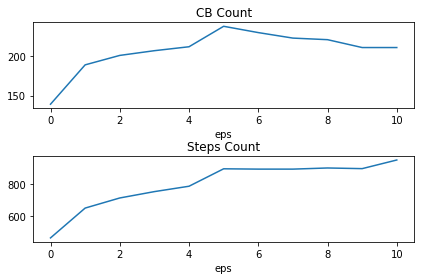

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes[0].set_title('CB Count')
axes[1].set_title('Steps Count')
Counts['CB Count'].plot(ax=axes[0])
Counts['Steps Count'].plot(ax=axes[1])
fig.tight_layout(h_pad=0.1)
fig.savefig('CB_StepsCount.png',dpi=100)

In [19]:
YHEData.shape

(75, 16)

In [56]:
CountsExp = getCBofAllGames(YHEData)
CountsExp['Steps Count %'] = CountsExp['Steps Count']/(YHEData.shape[0]/100)
CountsExp

,CB Count,Steps Count,Steps Count %
eps,,,
0,11,27,36.000000
1,11,28,37.333333
2,12,30,40.000000
3,12,30,40.000000
4,12,30,40.000000
5,17,40,53.333333
6,17,40,53.333333
7,17,40,53.333333
8,17,40,53.333333


## Для графиков числа КП и шагов в них

In [16]:
Meta={'basecount':YHData.shape[0],'expcount':YHEData.shape[0]}

### Для статьи "КП итог"

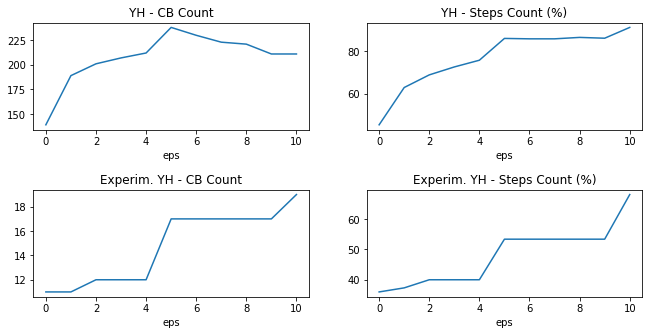

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].set_title('YH - CB Count')
axes[1,0].set_title('Experim. YH - CB Count')
axes[0,1].set_title('YH - Steps Count (%)')
axes[1,1].set_title('Experim. YH - Steps Count (%)')
CountsExp['CB Count'].plot(ax=axes[1,0])
(CountsExp['Steps Count']/(Meta['expcount']/100)).plot(ax=axes[1,1])
Counts['CB Count'].plot(ax=axes[0,0])
(Counts['Steps Count']/(Meta['basecount']/100)).plot(ax=axes[0,1])
fig.tight_layout(h_pad=0.1)
fig.set_size_inches((10,5))
fig.savefig('YHE_CB_StepsCount.png',dpi=150)

### Для презентации на УБС-2018

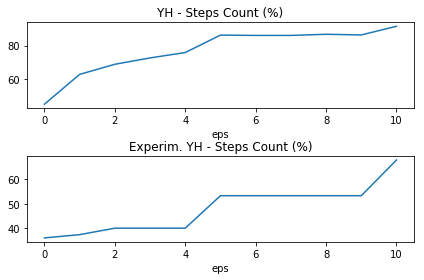

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=1)
#axes[0,0].set_title('YH - CB Count')
#axes[1,0].set_title('Experim. YH - CB Count')
axes[0].set_title('YH - Steps Count (%)')
axes[1].set_title('Experim. YH - Steps Count (%)')
#CountsExp['CB Count'].plot(ax=axes[1,0])
CountsExp['Steps Count'].plot(ax=axes[1])
#Counts['CB Count'].plot(ax=axes[0,0])
Counts['Steps Count'].plot(ax=axes[0])
fig.tight_layout(h_pad=0.1)
#fig.set_size_inches((10,5))
fig.savefig('YHE_CB_StepsCount.png',dpi=150)

In [82]:
CountsExp['Steps Count']/75

eps
0     0.360000
1     0.373333
2     0.400000
3     0.400000
4     0.400000
5     0.533333
6     0.533333
7     0.533333
8     0.533333
9     0.533333
10    0.680000
Name: Steps Count, dtype: float64

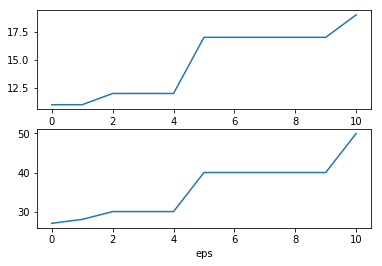

In [61]:
fig, axes = plt.subplots(nrows=2, ncols=1)
CountsExp['CB Count'].plot(ax=axes[0])
CountsExp['Steps Count'].plot(ax=axes[1])
fig.savefig('YHE_CB_StepsCount.png',dpi=100)

In [64]:
GLData[['Time','x']].iloc[-3:]

,Time,x
6411,8,22.133333
6412,8,42.333333
6413,8,50.533333


### Распределение, эфф-е по Нэш-торгам

NashOpt - оптимальное распределение ресурсов для максимизации функции торгов Нэша $ \Pi_i (u_i(x_i)-u_i(0)) $ :

In [ ]:
NashOpt=[32.0724,39.1355,43.7921]

In [115]:
gamegroups = GLData.groupby('Game')

a = []
for g,data in gamegroups:
    data.sort_values(by=['Time','GrSubject'])
    a.append( data['x'].iloc[-3:].values )

In [116]:
a

[array([38.13333333, 44.        , 32.86666667]),
 array([42.06666667, 41.70833333, 31.225     ]),
 array([ 166.66666667,   53.75      , -152.5       ]),
 array([ 0.15, 66.25, 48.6 ]),
 array([33.       , 28.5034256, 53.4965744]),
 array([41., 49., 25.]),
 array([25., 49., 41.]),
 array([41., 25., 49.]),
 array([25., 49., 41.]),
 array([24.83333333, 41.33333333, 48.83333333]),
 array([65.,  0., 50.]),
 array([ 43.33333333, -28.33333333, 100.        ]),
 array([45.  , 45.75, 24.25]),
 array([25., 41., 49.]),
 array([ 0. , 69.5, 45.5]),
 array([34.33333333, 42.        , 38.66666667]),
 array([32.33333333, 32.66666667, 46.66666667]),
 array([47.33333333, 21.66666667, 46.        ]),
 array([25., 49., 41.]),
 array([53.66666667, 26.75      , 34.58333333]),
 array([37.6       , 38.96666667, 38.4       ]),
 array([27.5       , 40.25      , 45.83333333]),
 array([48.33333333, 22.13333333, 44.53333333]),
 array([52.83333333, 38.33333333, 23.5       ]),
 array([46.33333333, 22.33333333, 46.333333

In [81]:
from scipy.spatial import distance

In [119]:
npd = distance.cdist(a,[[115/3,115/3,115/3],[49,41,25],[32.0724, 39.1355, 43.7921]],'cityblock')
npd2 = distance.cdist(a,[[115/3,115/3,115/3],[49,41,25],[32.0724, 39.1355, 43.7921]],'euclidean')

[np.mean(npd,axis=0),np.mean(npd2,axis=0)]

[array([41.02181685, 49.6502236 , 42.39936481]),
 array([26.79171582, 32.52246141, 27.75504135])]

In [96]:
gamegroups = YHData.groupby('Game')

In [97]:
a = []
for g,data in gamegroups:
    data.sort_values(by=['Time','GrSubject'])
    a.append( data['x'].iloc[-3:].values )

In [99]:
npd = distance.cdist(a,[[49,41,25],[22.81,115/3,53.85]],'cityblock')
npd2 = distance.cdist(a,[[49,41,25],[22.81,115/3,53.85]],'euclidean')

In [100]:
np.mean(npd,axis=0)

array([51.26294136, 53.61308444])

In [101]:
np.mean(npd2,axis=0)

array([32.4326487 , 34.89020465])

In [98]:
a

[array([38.33333333, 38.33333333, 38.33333333]),
 array([50.88495575, 40.7079646 , 23.40707965]),
 array([68.69666408, 44.60822343,  1.69511249]),
 array([43.07116105, 22.39700375, 49.53183521]),
 array([24.64285714, 65.71428571, 24.64285714]),
 array([45.72289157, 53.1124498 , 16.16465863]),
 array([  3.74230431,  10.11433597, 101.14335972]),
 array([37.77444254, 39.45111492, 37.77444254]),
 array([ 8.69747899,  9.66386555, 96.63865546]),
 array([37.57523646, 37.87188306, 39.55288048]),
 array([35.63511327, 43.72977346, 35.63511327]),
 array([32.45967742, 46.37096774, 36.16935484]),
 array([27.38095238, 21.9047619 , 65.71428571]),
 array([39.57322552, 37.1967655 , 38.23000898])]

In [102]:
def f(x,r):
    import math
    return math.sqrt(r+x)-math.sqrt(r)

In [103]:
def Nf(x,r):
    return f(x[0],r[0])*f(x[1],r[1])*f(x[2],r[2])

In [107]:
Nf([22.81,115/3,53.85],[1,9,25])

58.39938875025514

In [105]:
Nf([20,40,55],[1,9,25])

56.522610716240145

In [108]:
Nf([115/3,115/3,115/3],[1,9,25])

60.50607771202381

In [109]:
22.81+115/3+53.85

114.99333333333334

In [110]:
Nf([32.0724, 39.1355, 43.7921],[1,9,25])

61.62857193511759

In [114]:
Nf([49,41,25],[1,9,25])

51.187950266179705

## Оценка распределения длин КП

In [10]:
cbs = getCBwithEps(YHData)

In [11]:
notStoppedCbs = cbs[cbs['te']!=cbs['gamelength']]

In [12]:
lengths = (notStoppedCbs['te']-notStoppedCbs['ts'])

In [13]:
lengths.values

array([1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 3, 8, 3, 5, 1, 1, 1,
       1, 2, 3, 2, 2, 2, 1, 5, 1, 1, 6, 2, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       4, 2, 5, 1, 1, 1, 1, 1, 5, 4, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1,
       1, 4, 5, 1, 3, 2, 1, 2, 2, 2, 1, 7, 3, 2, 1, 1, 1, 1, 3, 2, 3, 6,
       1, 6, 8, 1, 8, 1, 3, 11, 1, 2, 5, 1, 1, 1, 2, 1, 2, 6, 3, 1, 3, 1,
       2, 4, 1, 1, 4, 1, 3, 2], dtype=object)

In [2]:
from scipy import stats
from scipy.stats import logser
from statsmodels.base.model import GenericLikelihoodModel

In [15]:
class LogFit(GenericLikelihoodModel):
    def __init__(self, endog, exog=None, **kwds):
        if exog is None:
            exog = np.zeros_like(endog)
            
        super(LogFit, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):

        return -np.log(logser.pmf(self.endog, p=params[0]))
    
    def fit(self, start_params=None, maxiter=10000, maxfun=5000, **kwds):
        if start_params is None:
            excess_zeros = 0.5 #(self.endog == 0).mean() - stats.poisson.pmf(0, lambda_start)
            
            start_params = np.array([excess_zeros])
            
        return super(LogFit, self).fit(start_params=start_params,
                                                    maxiter=maxiter, maxfun=maxfun, **kwds)

In [20]:
results = LogFit(lengths.values.tolist()).fit()

Optimization terminated successfully.
         Current function value: 1.520917
         Iterations: 14
         Function evaluations: 28


In [21]:
plog = results.params.item()

In [22]:
plog

0.7646484375000007

In [66]:
notStoppedCbs.shape

(118, 5)

In [74]:
118*(1-logser.pmf(1,plog)-logser.pmf(2,plog)-logser.pmf(3,plog)-logser.pmf(4,plog)-logser.pmf(5,plog)-logser.pmf(6,plog)) #smallclass

5.676809626210824

smallclass <~ 5 then use classes 1,2,3,4,5,[6,...]

In [108]:
def myclass(a):
    if a > 4:
        return 5
    else:
        return a

In [96]:
lengths.index = lengths.values

In [109]:
histclasses = lengths.groupby(myclass).count()

In [110]:
histclasses

1    63
2    21
3    13
4     5
5    16
dtype: int64

In [113]:
expclassesp = [logser.pmf(1,plog),logser.pmf(2,plog),logser.pmf(3,plog),logser.pmf(4,plog)]
expclassesp.append( 1 - np.sum(expclassesp) )

In [114]:
expclasses = np.multiply(118,expclassesp)

In [117]:
stats.chisquare(histclasses.values,expclasses,1)

Power_divergenceResult(statistic=1.84401018997024, pvalue=0.6054049725007631)

### Гипотеза падения выигрышей

In [67]:
arr = np.loadtxt('2.txt')

In [61]:
np.shape(arr)

(2, 198)

In [46]:
stats.wilcoxon(arr[0],arr[1],zero_method='wilcox')

WilcoxonResult(statistic=2110.0, pvalue=6.705348674323277e-06)

In [23]:
d=pd.DataFrame(arr[0]-arr[1])

In [25]:
d['abs']=abs(d[0])

In [30]:
dsrt = d.sort_values(by='abs')

In [39]:
dsrtnn = dsrt[dsrt['abs']>0].copy()

In [40]:
dsrtnn['rank'] = range(1,dsrtnn.shape[0]+1)

In [45]:
dsrtnn[dsrtnn[0]<0]['rank'].sum()

2110

In [51]:
(np.sign(dsrtnn[0])*dsrtnn['rank']).sum()

3655.0

In [52]:
from math import sqrt

In [53]:
n = 125
sigma = sqrt( n*(n+1)*(2*n+1)/6 )

In [54]:
sigma

811.7111555227019

In [55]:
sigma*1.96

1590.9538648244957

In [57]:
2*(1-stats.norm.cdf(3655.0/sigma))

6.7053486743073876e-06

In [68]:
stats.mannwhitneyu(arr[0],arr[1],alternative='less')

MannwhitneyuResult(statistic=20470.5, pvalue=0.9997420978922387)

## Нэш-торги

In [7]:
YHg=YHData.groupby(['Game','Time'])

In [46]:
YHData.shape

(1035, 16)

In [32]:
YHg.sum()

Group  GrSubject  Type       Gain   Penalty      x   s1     s2  \
Game Time                                                                   
40   1         3          6  35.0   6.812121  11.59900  115.0  0.0  215.0   
     2         3          6  35.0   6.808913  11.62040  115.0  0.0  215.1   
     3         3          6  35.0   6.812121  11.59900  115.0  0.0  215.0   
     4         3          6  35.0  15.951731   2.57165  115.0  0.0  102.6   
     5         3          6  35.0   6.833104  14.15300  115.0  0.0  216.5   
     6         3          6  35.0  11.057325   7.45100  115.0  0.0  172.0   
     7         3          6  35.0  15.000859   3.33200  115.0  0.0  121.1   
     8         3          6  35.0  15.015961   3.34400  115.0  0.0  121.2   
     9         3          6  35.0  14.507315   6.40000  115.0  0.0  140.0   
     10        3          6  35.0  13.965651   7.14000  115.0  0.0  151.0   
     11        3          6  35.0  15.947102   4.46180  115.0  0.0  134.8   
     12        3          6  35.0  13.840881   4.69100  115.0  0.0  142.0   
     13        3          6  35.0   2.249649  18.95000  115.0  0.0  245.0   
     14        3          6  35.0   6.857738  14.00000  115.0  0.0  215.0   
     15        3          6  35.0  19.004806   2.00000  115.0  0.0   85.0   
     16        3          6  35.0  19.492161   0.90000  115.0  0.0   60.0   
     17        3          6  35.0  19.242015   1.70000  115.0  0.0   75.0   
     18        3          6  35.0  19.184618   1.81000  115.0  0.0   77.0   
     19        3          6  35.0  19.358979   1.65000  115.0  0.0   75.0   
     20        3          6  35.0   9.501888  10.80000  115.0  0.0  195.0   
     21        3          6  35.0  10.900591   8.65000  115.0  0.0  185.0   
     22        3          6  35.0  19.732647   0.65500  115.0  0.0   56.0   
     23        3          6  35.0  13.439753   4.59100  115.0  0.0  152.0   
     24        3          6  35.0  13.636244   4.77050  115.0  0.0  156.1   
     25        3          6  35.0   5.450615  12.99100  115.0  0.0  227.0   
     26        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
     27        3          6  35.0  17.944727   0.86000  115.0  0.0   61.0   
     28        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
     29        3          6  35.0  17.742291   1.06500  115.0  0.0   66.0   
     30        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
...          ...        ...   ...        ...       ...    ...  ...    ...   
93   11        6          6  35.0  18.353990   1.58000  115.0  0.0   81.0   
     12        6          6  35.0  16.348287   4.77500  115.0  0.0  120.0   
     13        6          6  35.0  18.106282   3.00000  115.0  0.0   95.0   
     14        6          6  35.0  18.352494   2.67500  115.0  0.0   90.0   
     15        6          6  35.0  17.829075   3.32500  115.0  0.0  100.0   
     16        6          6  35.0  17.216159   3.97500  115.0  0.0  110.0   
     17        6          6  35.0  16.786546   4.37500  115.0  0.0  115.0   
     18        6          6  35.0  17.510346   3.66000  115.0  0.0  107.0   
     19        6          6  35.0  18.812764   2.17500  115.0  0.0   90.0   
     20        6          6  35.0  17.848249   3.20000  115.0  0.0  105.0   
94   1         9          6  35.0  18.719680   2.20000  115.0  0.0   82.0   
     2         9          6  35.0  14.307001   5.81500  115.0  0.0  146.0   
     3         9          6  35.0  15.672237   5.24000  115.0  0.0  127.0   
     4         9          6  35.0  17.203957   3.90600  115.0  0.0  108.3   
     5         9          6  35.0  14.287087   6.17750  115.0  0.0  143.3   
     6         9          6  35.0  18.472328   2.67500  115.0  0.0   90.0   
     7         9          6  35.0  18.515589   2.66100  115.0  0.0   90.0   
     8         9          6  35.0  18.861407   2.32600  115.0  0.0   85.0   
     9         9          6  35.0  14.976465   5.67600  115.0  0.0  135.0   
     10

### Функции расчёта выигрышей в игре

In [8]:
class Game:
    import numpy as np
    def __init__(self,R,s0,types):
        self.R = R
        self.s0 = np.array(s0)
        self.n = len(s0)
        self.types = np.array(types)
    def u(self,x):
        return self.np.sqrt(self.types+x)
game = Game( 115,(115/3,115/3,115/3), (1,9,25))

In [9]:
class Mechanism:
    def __init__(self,game,params,xfunc,tfunc):
        self.game = game
        for k,v in params.items():
            setattr(self,k,v)
        self.xfunc = xfunc
        self.tfunc = tfunc
        
    def x(self,s):
        return self.xfunc(s,self.game)
    def t(self,s):
        return self.tfunc(s,self.game,self)
    def f(self,s):
        return game.u(self.x(s))-self.t(s)

YHMechanism = Mechanism(game,
                        {'beta':0.0005}, 
                        lambda s,g: s*g.R/s.sum(),
                        lambda s,g,m: m.beta*s*(np.repeat(s.sum(),3)-s))

class GLClass:
    from scipy.spatial import distance
    def __init__(self):
        self.glx = lambda s,g: s.sum(axis=0) / g.n
    def glt(self,s,g,m):
        p = m.beta * self.distance.cdist([self.glx(s,g)],s,'sqeuclidean')
        pmean = m.alfa * p.mean()
        return p - pmean
GL = GLClass()
    
GLMechanism = Mechanism(game,{'beta':0.0005,'alfa':1},
                        GL.glx,
                        GL.glt
                       )

In [104]:
s = np.array([[70,33.248853,11.751147],[26.5,77,11.5],[21.143719,33.856281,60]])
print(GLMechanism.x(s),GLMechanism.t(s),GLMechanism.f(s))

[39.214573   48.03504467 27.75038233] [[ 0.00206069 -0.0767621   0.07470141]] [[6.33943543 7.62891707 7.18824444]]


In [101]:
GLData.iloc[1800:1803]

,Game,Time,Subject,Group,GrSubject,Type,Gain,Penalty,x,s1,s2,s3,AcceptAdvice,CalcCount,CalcAdviceCount,UseHelp
3534,51,8,11,4,3,25.0,7.188244,0.074701,27.750382,21.143719,33.856281,60.000000,1.0,0.0,1.0,NaN
3535,51,8,12,4,1,1.0,6.339435,0.002061,39.214573,70.000000,33.248853,11.751147,1.0,0.0,6.0,NaN
3536,51,8,10,4,2,9.0,7.628917,-0.076762,48.035044,26.500000,77.000000,11.500000,0.0,0.0,0.0,NaN


In [126]:
p=YHData.iloc[21:24]
p.sort_values(by="GrSubject")
print(p)

      Game  Time Subject  Group  GrSubject  Type      Gain  Penalty  \
2553    40     8       6      1          2   9.0  5.228284    1.624   
2554    40     8      10      1          3  25.0  8.397277    1.648   
2555    40     8      11      1          1   1.0  1.390400    0.072   

              x  s1    s2  s3  AcceptAdvice  CalcCount  CalcAdviceCount  \
2553  37.953795 NaN  40.0 NaN           0.0        0.0              0.0   
2554  75.907591 NaN  80.0 NaN           0.0        1.0              0.0   
2555   1.138614 NaN   1.2 NaN           0.0        0.0              0.0   

      UseHelp  
2553      1.0  
2554      1.0  
2555      2.0  


In [11]:
print(YHMechanism.beta)
s = np.array([1.2,40,80])
print(YHMechanism.t(s))
YHMechanism.f(s)

0.0005
[0.072 1.624 1.648]


array([1.39040003, 5.22828395, 8.39727704])

In [12]:
def Unash(f,f0):
    return (f-f0).prod()

print(YHMechanism.game.s0)

f0 = YHMechanism.game.u([0,0,0])
print(f0)

Unash(f0,s)

[38.33333333 38.33333333 38.33333333]
[1. 3. 5.]


-554.9999999999999

In [115]:
import itertools
res = []
for name,group in YHg:
    group = group.sort_values(by='GrSubject')
    if name[1] == 1 :
        curname = name[0]
        prevg = group
        continue
    
    fprev = prevg['Gain'].values
    sprev = prevg['s2'].values
    s = group['s2'].values
    s1, s2, s3 = sprev.copy(), sprev.copy(), sprev.copy()
    s1[0] = s[0]
    s2[1] = s[1]
    s3[2] = s[2]
    f1 = YHMechanism.f(s1)
    f2 = YHMechanism.f(s2)
    f3 = YHMechanism.f(s3)
    U = Unash(fprev,f0)
    U1 = Unash(f1,f0)
    U2 = Unash(f2,f0)
    U3 = Unash(f3,f0)
    Unew = Unash(YHMechanism.f(s),f0)
    res.append( [a for a in itertools.chain(name,[U1>U,U2>U,U3>U,Unew>U,U,U1,U2,U3,Unew])] )
    prevg = group
    #print(name,prev['Gain'])

In [116]:
a = np.vstack(res)

In [117]:
pda = pd.DataFrame(a); pda

,0,1,2,3,4,5,6,7,8,9,10
0,40.0,2.0,1.0,0.0,0.0,1.0,0.166445,0.182068,0.166445,0.166445,0.182068
1,40.0,3.0,0.0,1.0,1.0,0.0,0.182068,0.166445,0.182068,0.182068,0.166445
2,40.0,4.0,1.0,1.0,0.0,1.0,0.166445,0.182068,0.663205,0.141136,4.637448
3,40.0,5.0,0.0,0.0,1.0,0.0,4.637448,2.334728,4.523720,4.758127,2.365943
4,40.0,6.0,1.0,0.0,0.0,0.0,2.365943,4.312664,-42.795611,-2.119715,0.061842
5,40.0,7.0,1.0,1.0,0.0,1.0,0.061842,0.064509,2.568412,0.061842,2.765782
6,40.0,8.0,1.0,1.0,1.0,1.0,2.765782,2.955366,2.765782,2.765782,2.955366
7,40.0,9.0,0.0,0.0,1.0,1.0,2.955366,1.349725,2.955366,5.147459,5.049548
8,40.0,10.0,0.0,1.0,1.0,0.0,5.049548,-0.238005,6.277598,11.369736,0.827750
9,40.0,11.0,1.0,0.0,1.0,1.0,0.827750,22.653564,0.456697,3.488995,3.342179


In [109]:
pda = pda[[2,3,4,5]]

## YH

Игры с механизмом YH и механизмом остановки "по договорённости" - никто не поменял заявок.
Всего шагов 1035, если брать для каждого игрока в отдельности, то 3105 = 1035 * 3

Функция Нэша: $ U(f,f^0)=\prod_{i} (f_i -f_i^0) $

Базовые выигрыши: $ f^0 = u(0,0,0) $

Определения для текущего шага $t>1$: $$ U_{prev} = U(f(s^{t-1}),f^0) $$
$$ U_i =U(f(s_i^t,s_{-i}^{t-1}),f^0) $$
$$ U_{new}=U(f(s^t),f^0) $$

In [118]:
pda[pda[2]>0]

,0,1,2,3,4,5,6,7,8,9,10
0,40.0,2.0,1.0,0.0,0.0,1.0,0.166445,0.182068,0.166445,0.166445,0.182068
2,40.0,4.0,1.0,1.0,0.0,1.0,0.166445,0.182068,0.663205,0.141136,4.637448
4,40.0,6.0,1.0,0.0,0.0,0.0,2.365943,4.312664,-42.795611,-2.119715,0.061842
5,40.0,7.0,1.0,1.0,0.0,1.0,0.061842,0.064509,2.568412,0.061842,2.765782
6,40.0,8.0,1.0,1.0,1.0,1.0,2.765782,2.955366,2.765782,2.765782,2.955366
9,40.0,11.0,1.0,0.0,1.0,1.0,0.827750,22.653564,0.456697,3.488995,3.342179
12,40.0,14.0,1.0,0.0,1.0,1.0,-8.576736,-0.789690,-70.726083,-8.576736,0.096981
14,40.0,16.0,1.0,1.0,1.0,1.0,9.742060,18.127277,9.742060,14.618917,26.487439
19,40.0,21.0,1.0,0.0,1.0,0.0,-0.011539,1.428371,-30.885469,5.049548,-1.353537
22,40.0,24.0,1.0,0.0,1.0,0.0,0.811101,0.872280,0.343788,7.132009,0.065471


In [110]:
a = (pda[pda>0].count()).values

In [113]:
pd.DataFrame({'Критерии':['U1 > Uprev','U2 > Uprev','U3 > Uprev','U1>Uprev & U2>Uprev & U3>Uprev',
                          'U1>Uprev & U2>Uprev & U3>Uprev & Unew > Uprev','Unew > Uprev',
                          'Unew > Uprev & Exist Ui < Uprev','Unew > Uprev & All Ui < Uprev'],
              'Число подходящих ходов':[a[0],a[1],a[2],pda[(pda[2]*pda[3]*pda[4]==1)].shape[0],
                                       pda[pda[2]*pda[3]*pda[4]*pda[5]==1].shape[0],
                                       pda[pda[5]==1].shape[0],pda[(pda[5]==1) & (pda[2]*pda[3]*pda[4]==0)].shape[0],
                                       pda[(pda[5]==1) & (pda[2]+pda[3]+pda[4]==0)].shape[0]
                                       ]
             })

,Критерии,Число подходящих ходов
0,U1 > Uprev,177
1,U2 > Uprev,179
2,U3 > Uprev,189
3,U1>Uprev & U2>Uprev & U3>Uprev,63
4,U1>Uprev & U2>Uprev & U3>Uprev & Unew > Uprev,63
5,Unew > Uprev,165
6,Unew > Uprev & Exist Ui < Uprev,102
7,Unew > Uprev & All Ui < Uprev,0


In [13]:
YH40 = YHData[YHData['Game']==40].groupby(['Game','Time'])

In [15]:
YH40.sum()

Group  GrSubject  Type       Gain   Penalty      x   s1     s2  \
Game Time                                                                   
40   1         3          6  35.0   6.812121  11.59900  115.0  0.0  215.0   
     2         3          6  35.0   6.808913  11.62040  115.0  0.0  215.1   
     3         3          6  35.0   6.812121  11.59900  115.0  0.0  215.0   
     4         3          6  35.0  15.951731   2.57165  115.0  0.0  102.6   
     5         3          6  35.0   6.833104  14.15300  115.0  0.0  216.5   
     6         3          6  35.0  11.057325   7.45100  115.0  0.0  172.0   
     7         3          6  35.0  15.000859   3.33200  115.0  0.0  121.1   
     8         3          6  35.0  15.015961   3.34400  115.0  0.0  121.2   
     9         3          6  35.0  14.507315   6.40000  115.0  0.0  140.0   
     10        3          6  35.0  13.965651   7.14000  115.0  0.0  151.0   
     11        3          6  35.0  15.947102   4.46180  115.0  0.0  134.8   
     12        3          6  35.0  13.840881   4.69100  115.0  0.0  142.0   
     13        3          6  35.0   2.249649  18.95000  115.0  0.0  245.0   
     14        3          6  35.0   6.857738  14.00000  115.0  0.0  215.0   
     15        3          6  35.0  19.004806   2.00000  115.0  0.0   85.0   
     16        3          6  35.0  19.492161   0.90000  115.0  0.0   60.0   
     17        3          6  35.0  19.242015   1.70000  115.0  0.0   75.0   
     18        3          6  35.0  19.184618   1.81000  115.0  0.0   77.0   
     19        3          6  35.0  19.358979   1.65000  115.0  0.0   75.0   
     20        3          6  35.0   9.501888  10.80000  115.0  0.0  195.0   
     21        3          6  35.0  10.900591   8.65000  115.0  0.0  185.0   
     22        3          6  35.0  19.732647   0.65500  115.0  0.0   56.0   
     23        3          6  35.0  13.439753   4.59100  115.0  0.0  152.0   
     24        3          6  35.0  13.636244   4.77050  115.0  0.0  156.1   
     25        3          6  35.0   5.450615  12.99100  115.0  0.0  227.0   
     26        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
     27        3          6  35.0  17.944727   0.86000  115.0  0.0   61.0   
     28        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
     29        3          6  35.0  17.742291   1.06500  115.0  0.0   66.0   
     30        3          6  35.0  17.776815   1.07150  115.0  0.0   66.1   
     31        3          6  35.0  17.742291   1.06500  115.0  0.0   66.0   
     32        3          6  35.0  17.598476   3.60000  115.0  0.0  105.0   
     33        3          6  35.0  17.116473   4.05500  115.0  0.0  112.0   
     34        3          6  35.0  17.042679   4.11100  115.0  0.0  113.0   
     35        3          6  35.0  16.707016   4.48500  115.0  0.0  118.0   
     36        3          6  35.0  18.194570   2.78400  115.0  0.0  101.0   
     37        3          6  35.0   7.160956  13.34400  115.0  0.0  211.0   
     38        3          6  35.0  17.310031   1.77500  115.0  0.0  130.0   
     39        3          6  35.0  19.647432   0.69500  115.0  0.0   56.0   
     40        3          6  35.0  19.609865   0.65000  115.0  0.0   55.0   
     41        3          6  35.0  19.647432   0.69500  115.0  0.0   56.0   
     42        3          6  35.0  18.736173   1.65000  115.0  0.0   75.0   
     43        3          6  35.0  16.748558   3.15500  115.0  0.0  116.0   
     44        3          6  35.0  16.771674   3.05000  115.0  0.0  115.0   
     45        3          6  35.0  18.235891   1.33500  115.0  0.0   96.0   
     46        3          6  35.0   8.222200  11.15000  115.0  0.0  205.0   
     47        3          6  35.0  17.645870   1.39100  115.0  0.0  127.0   
     48        3          6  35.0  18.736173   1.65000  115.0  0.0   75.0   
     49        3          6  35.0  18.439013   1.97000  115.0  0.0   81.0   
     50        3          6  35.0  17.845657   2.70000  115.0  0.0   95.0   
     51